In [1]:
import numpy as np
import pandas as pd
import os
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models,Sequential,metrics,callbacks
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix,roc_curve
import matplotlib.pyplot as plt
from imblearn.over_sampling import RandomOverSampler

In [2]:
os.chdir('..\\Desktop')

In [3]:
# get the dataset and split into train and test
df = pd.read_csv('creditcard.csv')
x = df.drop('Class',axis=1).values
y = df['Class'].values
xtrain,xtest,ytrain,ytest = train_test_split(x, y,test_size=0.2,random_state=122)
print('Number of training samples: ',len(xtrain))
print('NUmber of testing examples: ',len(xtest))

Number of training samples:  227845
NUmber of testing examples:  56962


In [4]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [5]:
# get percentage of labels in the dataset 
counts = np.bincount(ytrain)
negative,positive = counts
print('The percentage of positive lables in training dataset is {:.4f}%'.format(100*positive/len(ytrain)))
print('The percentage of negative lables in training dataset is {:.4f}%'.format(100*negative/len(ytrain)))

The percentage of positive lables in training dataset is 0.1712%
The percentage of negative lables in training dataset is 99.8288%


In [6]:
# This dataset is highly imbalanced the method is to use class weigthed parameter in keras 
# model fit method
weight_1 = 1.0/counts[1]
weight_0 = 1.0/counts[0]
print(weight_1)
print(weight_0)

0.002564102564102564
4.396474027829681e-06


In [7]:
# normalization
scaler = StandardScaler()
xtrain = scaler.fit_transform(xtrain)
xtest = scaler.transform(xtest)

In [8]:
# define the evaluation metrics for binary classifiction 
METRICS = [
    metrics.FalseNegatives(name='fn'),
    metrics.FalsePositives(name='fp'),
    metrics.TruePositives(name='tp'),
    metrics.TrueNegatives(name='tn'),
    metrics.Precision(name='precision'),
    metrics.Recall(name='recall'),
    metrics.AUC(name='auc')
]

In [9]:
# define model structure
def build_model(metircs = METRICS):
    inputs = keras.Input(shape=(xtrain.shape[-1],))
    x = layers.Dense(32,activation='relu',kernel_initializer='he_normal')(inputs)
    x = layers.Dense(16,activation='relu',kernel_initializer='he_normal')(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(1,activation='sigmoid')(x)
    model = keras.Model(inputs,outputs)
    
    model.compile(loss=keras.losses.BinaryCrossentropy(),
                  optimizer=keras.optimizers.Adam(1e-3),
                  metrics=metircs)
    return model

In [10]:
# training parameters
epochs = 100
batch_size= 612
estoping = callbacks.EarlyStopping(monitor='val_fn',patience=10,restore_best_weights=True)
# In this case, we set monitor to false negative (Type II error) becuase it is more important than
# Type I error false positive.The model need to detect as much fraudulent transactions as possible
# so that false negative is metrics we need to look up.

In [11]:
# training base_model
base_model = build_model(metircs = METRICS)
history_base = base_model.fit(xtrain,ytrain
               ,validation_data=(xtest,ytest)
               ,epochs=epochs,callbacks=[estoping]
               ,batch_size=batch_size)

Epoch 1/100
373/373 [==============================] - 2s 6ms/step - loss: 0.0748 - fn: 261.0000 - fp: 3793.0000 - tp: 129.0000 - tn: 223662.0000 - precision: 0.0329 - recall: 0.3308 - auc: 0.6966 - val_loss: 0.0077 - val_fn: 46.0000 - val_fp: 9.0000 - val_tp: 56.0000 - val_tn: 56851.0000 - val_precision: 0.8615 - val_recall: 0.5490 - val_auc: 0.8612
Epoch 2/100
373/373 [==============================] - 2s 5ms/step - loss: 0.0133 - fn: 160.0000 - fp: 133.0000 - tp: 230.0000 - tn: 227322.0000 - precision: 0.6336 - recall: 0.5897 - auc: 0.8757 - val_loss: 0.0054 - val_fn: 37.0000 - val_fp: 12.0000 - val_tp: 65.0000 - val_tn: 56848.0000 - val_precision: 0.8442 - val_recall: 0.6373 - val_auc: 0.8918
Epoch 3/100
373/373 [==============================] - 2s 5ms/step - loss: 0.0093 - fn: 141.0000 - fp: 104.0000 - tp: 249.0000 - tn: 227351.0000 - precision: 0.7054 - recall: 0.6385 - auc: 0.9050 - val_loss: 0.0048 - val_fn: 37.0000 - val_fp: 10.0000 - val_tp: 65.0000 - val_tn: 56850.0000 - va

In [12]:
# save the model weight
base_model.save_weights('base_model.h5')

In [13]:
# define class weighted model
model_with_class_weights = build_model(metircs = METRICS)
history_weighted = model_with_class_weights.fit(xtrain,ytrain,validation_data=(xtest,ytest)
                    ,epochs=epochs
                    ,callbacks=[estoping]
                    ,batch_size=batch_size
                    ,class_weight=({0:weight_0,1:weight_1}))
# save the model weight
model_with_class_weights.save_weights('class_weighted_model.h5')

Epoch 1/100
373/373 [==============================] - 2s 6ms/step - loss: 1.0038e-05 - fn: 160.0000 - fp: 82480.0000 - tp: 332.0000 - tn: 201835.0000 - precision: 0.0040 - recall: 0.6748 - auc: 0.7503 - val_loss: 0.4655 - val_fn: 13.0000 - val_fp: 6663.0000 - val_tp: 89.0000 - val_tn: 50197.0000 - val_precision: 0.0132 - val_recall: 0.8725 - val_auc: 0.9291
Epoch 2/100
373/373 [==============================] - 2s 5ms/step - loss: 3.2583e-06 - fn: 70.0000 - fp: 23974.0000 - tp: 320.0000 - tn: 203481.0000 - precision: 0.0132 - recall: 0.8205 - auc: 0.9090 - val_loss: 0.2768 - val_fn: 14.0000 - val_fp: 1535.0000 - val_tp: 88.0000 - val_tn: 55325.0000 - val_precision: 0.0542 - val_recall: 0.8627 - val_auc: 0.9481
Epoch 3/100
373/373 [==============================] - 2s 5ms/step - loss: 2.4437e-06 - fn: 60.0000 - fp: 10025.0000 - tp: 330.0000 - tn: 217430.0000 - precision: 0.0319 - recall: 0.8462 - auc: 0.9445 - val_loss: 0.1878 - val_fn: 13.0000 - val_fp: 1035.0000 - val_tp: 89.0000 - v

In [14]:
# oversampling the minority class
oversampling = RandomOverSampler(sampling_strategy='minority')
xtrain_over,ytrain_over = oversampling.fit_resample(xtrain,ytrain)
xtest_over,ytest_over = oversampling.fit_resample(xtrain,ytrain)

In [15]:
# define oversampling model
oversampling_model = build_model(metircs = METRICS)
history_over = oversampling_model.fit(xtrain_over,ytrain_over,validation_data=(xtest_over,ytest_over)
                    ,epochs=epochs
                    ,callbacks=[estoping]
                    ,batch_size=batch_size)
# save the model weight
oversampling_model.save_weights('oversampling_model.h5')

Epoch 1/100
744/744 [==============================] - 6s 8ms/step - loss: 0.1675 - fn: 16638.0000 - fp: 14657.0000 - tp: 210919.0000 - tn: 269658.0000 - precision: 0.9350 - recall: 0.9269 - auc: 0.9852 - val_loss: 0.0511 - val_fn: 5924.0000 - val_fp: 3305.0000 - val_tp: 221531.0000 - val_tn: 224150.0000 - val_precision: 0.9853 - val_recall: 0.9740 - val_auc: 0.9986
Epoch 2/100
744/744 [==============================] - 6s 8ms/step - loss: 0.0515 - fn: 5280.0000 - fp: 3332.0000 - tp: 222175.0000 - tn: 224123.0000 - precision: 0.9852 - recall: 0.9768 - auc: 0.9985 - val_loss: 0.0238 - val_fn: 576.0000 - val_fp: 1934.0000 - val_tp: 226879.0000 - val_tn: 225521.0000 - val_precision: 0.9915 - val_recall: 0.9975 - val_auc: 0.9994
Epoch 3/100
744/744 [==============================] - 6s 8ms/step - loss: 0.0317 - fn: 2189.0000 - fp: 2579.0000 - tp: 225266.0000 - tn: 224876.0000 - precision: 0.9887 - recall: 0.9904 - auc: 0.9992 - val_loss: 0.0141 - val_fn: 0.0000e+00 - val_fp: 1053.0000 - va

In [16]:
# define a function to visualize training loss and validation loss
line_style = ['solid', 'dashed', 'dashdot', 'dotted']
def plot_loss(history,label,n,j):
    plt.semilogy(history.epoch, history.history['loss'],
                    linestyle=line_style[n],label='Train ' + label)
    plt.semilogy(history.epoch,history.history['val_loss'],
                 linestyle=line_style[j],label='Test ' + label)
    plt.xlabel('Epoch')
    plt.ylabel('loss')
    plt.legend()
    plt.show()

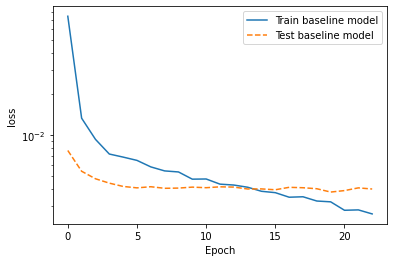

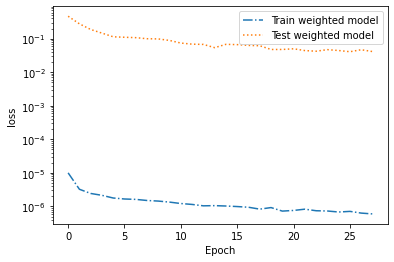

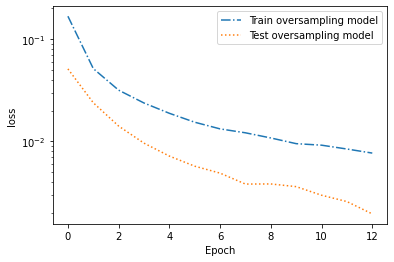

In [17]:
plot_loss(history_base,'baseline model',0,1)
plot_loss(history_weighted,'weighted model',2,3)
plot_loss(history_over,'oversampling model',2,3)

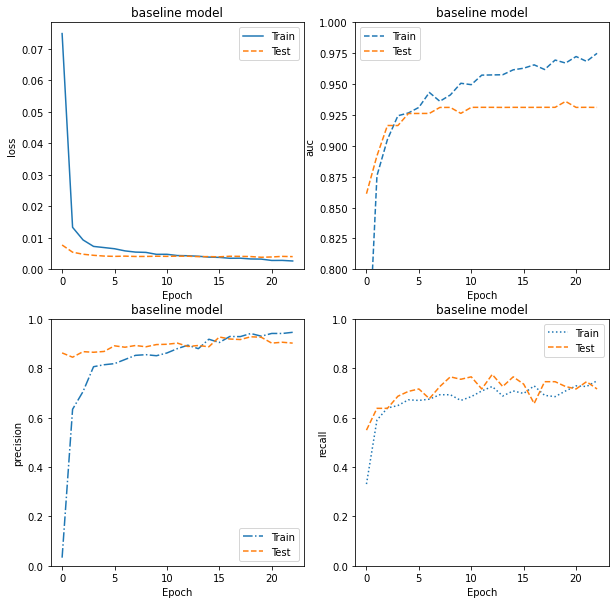

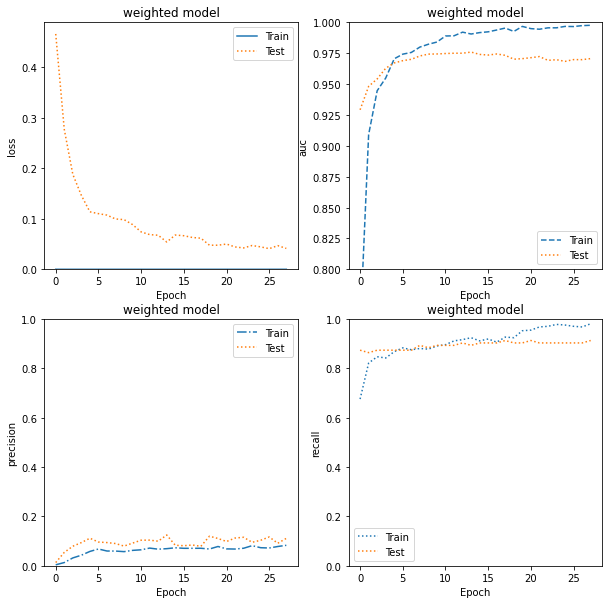

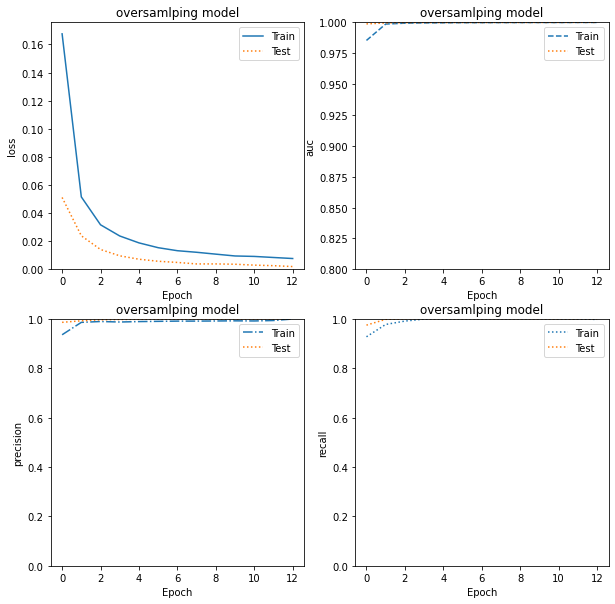

In [18]:
# define a function to visualize mertics
def plot_metrics(history,n,j,title=''):
    plt.figure(figsize=(10,10))
    metrics = ['loss','auc','precision','recall']
    for n, metric in enumerate(metrics):
        name = metric.replace('_',' ')
        plt.subplot(2,2,n+1)
        plt.plot(history.epoch,history.history[metric],linestyle=line_style[n],label='Train')
        plt.plot(history.epoch,history.history['val_'+metric],linestyle=line_style[j],label='Test')
        plt.xlabel('Epoch')
        plt.ylabel(name)
        plt.title(title)

        if metric == 'loss':
            plt.ylim([0,plt.ylim()[1]])
        elif metric == 'auc':
            plt.ylim([0.8,1])
        else:
            plt.ylim([0,1])
        plt.legend()
    plt.show()

plot_metrics(history_base,0,1,'baseline model')
plot_metrics(history_weighted,2,3,'weighted model')
plot_metrics(history_over,0,3,'oversamlping model')

In [19]:
train_predictions_baseline = base_model.predict(xtrain,batch_size=batch_size)
test_predictions_baseline = base_model.predict(xtest,batch_size=batch_size)
train_predictions_weighted = model_with_class_weights.predict(xtrain,batch_size=batch_size)
test_predictions_weighted = model_with_class_weights.predict(xtest,batch_size=batch_size)
train_predictions_oversampling = oversampling_model.predict(xtrain_over,batch_size=batch_size)
test_predictions_oversampling = oversampling_model.predict(xtest_over,batch_size=batch_size)

In [20]:
# define a heatmap funtion
def plot_hm(labels,predictions,p=0.5,title=''):
    hm = confusion_matrix(labels,predictions>p)
    plt.figure(figsize=(5,5))
    sns.heatmap(hm,annot=True,fmt='d')
    plt.title('Confusion metrix @ {:.2f} '.format(p) + title)
    plt.xlabel('Actual label')
    plt.ylabel('Predicted label')
    plt.show()

    print(title)
    print('Legitimate transaction detected (TP): ',hm[0][0])
    print('Legitimate transaction incorrectly detected (FP): ', hm[0][1])
    print('Fraudulent transaction missed (FN): ', hm[1][0])
    print('Fraudulent transaction detected (TN): ', hm[1][1])
    print('Total Fraudulent Transaction: ',np.sum(hm[1]))

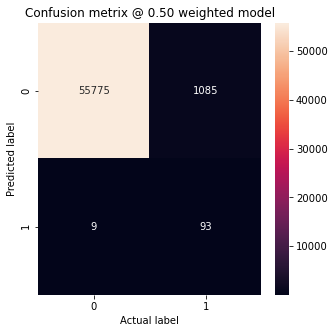

weighted model
Legitimate transaction detected (TP):  55775
Legitimate transaction incorrectly detected (FP):  1085
Fraudulent transaction missed (FN):  9
Fraudulent transaction detected (TN):  93
Total Fraudulent Transaction:  102


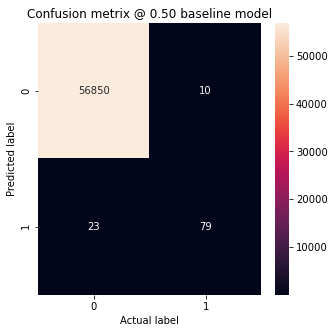

baseline model
Legitimate transaction detected (TP):  56850
Legitimate transaction incorrectly detected (FP):  10
Fraudulent transaction missed (FN):  23
Fraudulent transaction detected (TN):  79
Total Fraudulent Transaction:  102


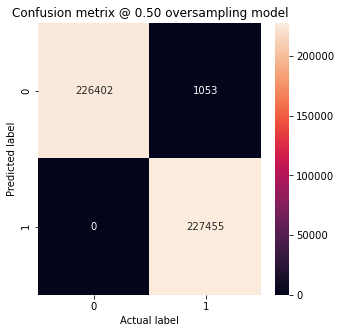

oversampling model
Legitimate transaction detected (TP):  226402
Legitimate transaction incorrectly detected (FP):  1053
Fraudulent transaction missed (FN):  0
Fraudulent transaction detected (TN):  227455
Total Fraudulent Transaction:  227455


In [21]:
plot_hm(ytest,test_predictions_weighted,p=0.5,title='weighted model')
plot_hm(ytest,test_predictions_baseline,p=0.5,title='baseline model')
plot_hm(ytest_over,test_predictions_oversampling,p=0.5,title='oversampling model')

In [22]:
# a function to plot ROC 
def plot_roc(name,labels,predictions,**kwargs):
    fp,tp,_, = roc_curve(labels,predictions)
    plt.plot(100*fp,100*tp,label=name,linewidth=2,**kwargs)
    plt.title(name)
    plt.xlabel('False positive [%]')
    plt.ylabel('True positive [%]')
    plt.xlim([-0.5,20])
    plt.ylim([80,100.5])
    plt.grid(True)
    plt.legend()
    plt.show()

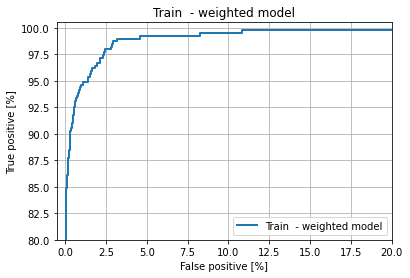

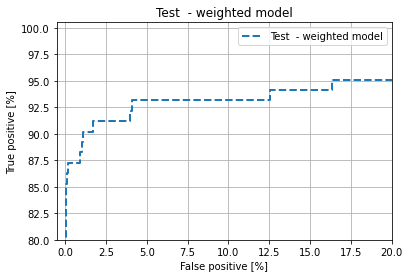

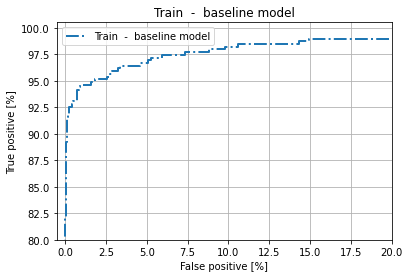

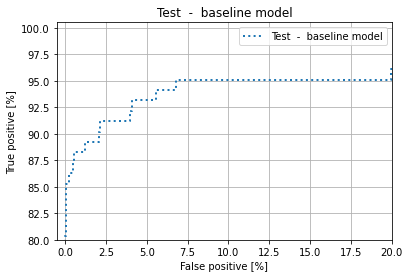

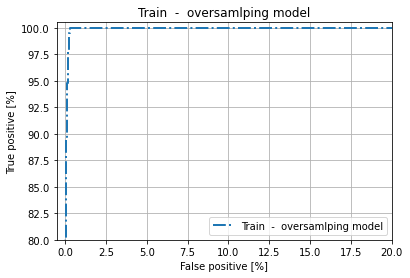

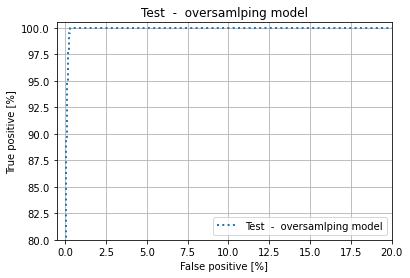

In [23]:
plot_roc('Train  - weighted model',ytrain,train_predictions_weighted,linestyle=line_style[0])
plot_roc('Test  - weighted model',ytest,test_predictions_weighted,linestyle=line_style[1])
plot_roc('Train  -  baseline model',ytrain,train_predictions_baseline,linestyle=line_style[2])
plot_roc('Test  -  baseline model',ytest,test_predictions_baseline,linestyle=line_style[3])
plot_roc('Train  -  oversamlping model',ytrain_over,train_predictions_oversampling,linestyle=line_style[2])
plot_roc('Test  -  oversamlping model',ytest_over,test_predictions_oversampling,linestyle=line_style[3])